In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('train.csv', index_col=0)

In [5]:
y = df['Survived']
X = df.drop(columns=['Survived'])

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2)

def data_clean(X_train, X_test):
    
    age_fill = X_train.groupby(['Pclass', 'Sex'])['Age'].median()
    #X_train = X_train.reset_index().set_index(['Pclass', 'Sex']).fillna({'Age':age_fill}).reset_index().set_index('PassengerId')
    #X_test = X_test.reset_index().set_index(['Pclass', 'Sex']).fillna({'Age':age_fill}).reset_index().set_index('PassengerId')
    X_train['Age'] = np.median(X_train['Age'].dropna())
    X_test['Age'] = np.median(X_train['Age'].dropna())
    
    X_train['Pclass'] = X_train['Pclass'].astype(object)
    X_test['Pclass'] = X_test['Pclass'].astype(object)
    X_train_cat = pd.get_dummies(X_train[['Pclass', 'Sex']])
    X_test_cat = pd.get_dummies(X_test[['Pclass', 'Sex']])
    X_train = pd.concat([X_train[['Age', 'Fare']], X_train_cat], axis=1)
    X_test = pd.concat([X_test[['Age', 'Fare']], X_test_cat], axis=1)
    return X_train, X_test

X_train_df, X_test_df = data_clean(X_train_df, X_test_df)
ss = StandardScaler()
ss.fit(X_train_df)
X_train = ss.transform(X_train_df)
X_test = ss.transform(X_test_df)

<ipython-input-5-a92a7ad7fb9b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Age'] = np.median(X_train['Age'].dropna())
<ipython-input-5-a92a7ad7fb9b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Age'] = np.median(X_train['Age'].dropna())
<ipython-input-5-a92a7ad7fb9b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [6]:
rf_parameters = {'max_depth': [None, 2, 3, 5],
                 'min_samples_split': [2, 10, 25, 50]}

rf = RandomForestClassifier()
rf_fit = GridSearchCV(rf, rf_parameters)
rf_fit.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 2, 3, 5],
                         'min_samples_split': [2, 10, 25, 50]})

In [8]:
rf_fit.best_estimator_

RandomForestClassifier(min_samples_split=10)

In [9]:
rf_fit.best_score_

0.8201418300009848

In [10]:
rf_fit.score(X_test, y_test)

0.7932960893854749

In [11]:
gb_parameters = {'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
                 'n_estimators': [20, 35, 50,75, 100],
                 'min_samples_split': [2, 10, 25, 50]}

gb = GradientBoostingClassifier()
gb_fit = GridSearchCV(gb, gb_parameters)
gb_fit.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
                         'min_samples_split': [2, 10, 25, 50],
                         'n_estimators': [20, 35, 50, 75, 100]})

In [12]:
gb_fit.best_estimator_

GradientBoostingClassifier(learning_rate=0.3, min_samples_split=10,
                           n_estimators=75)

In [13]:
gb_fit.best_score_

0.8313995863291639

In [14]:
gb_fit.score(X_test, y_test)

0.7988826815642458

In [15]:
lr_parameters = {'penalty': ['l2'],
                 'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

lr = LogisticRegression()
lr_fit = GridSearchCV(lr, lr_parameters)
lr_fit.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
                         'penalty': ['l2']})

In [16]:
lr_fit.best_estimator_

LogisticRegression(C=5.0)

In [17]:
lr_fit.best_score_

0.7850783019797104

In [18]:
lr_fit.score(X_test, y_test)

0.7932960893854749

In [19]:
predict_df = X_test_df.copy()
predict_df['y'] = y_test
predict_df['rf'] = rf_fit.predict_proba(X_test)[:,1]
predict_df['gb'] = gb_fit.predict_proba(X_test)[:,1]
predict_df['lr'] = lr_fit.predict_proba(X_test)[:,1]

value_cols = ['y', 'rf', 'gb', 'lr']

sex_df = predict_df.groupby(['Sex_male', 'Sex_female'])
sex_df = sex_df[value_cols].mean()


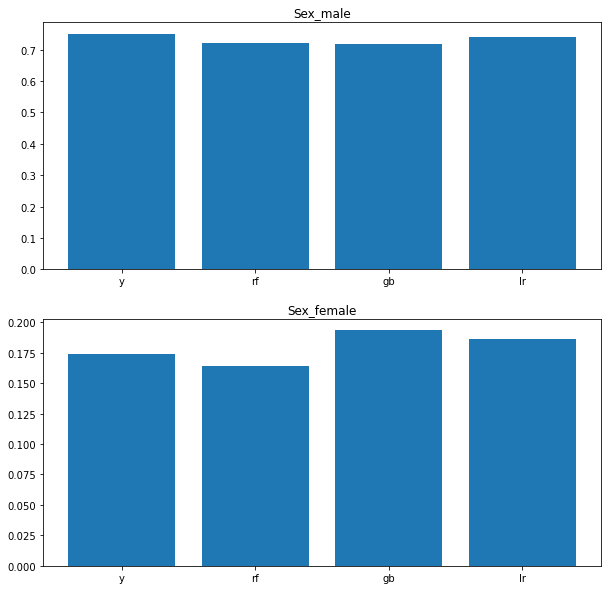

In [20]:
n = len(sex_df)

fig, ax = plt.subplots(n,1,figsize=(10,10))
for i, ind in enumerate(sex_df.index):
    ax[i].bar(sex_df.columns, sex_df.loc[ind])
    ax[i].set_title(sex_df.index.names[i])